In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock
import nltk

import seaborn as sns

In [2]:
def nearest_k(query, objects, k, dist):
    """Return the indices to objects most similar to query
    
    Parameters
    ----------
    query : ndarray
        query object represented in the same form vector representation as the
        objects
    objects : ndarray
        vector-represented objects in the database; rows correspond to 
        objects, columns correspond to features
    k : int
        number of most similar objects to return
    dist : function
        accepts two ndarrays as parameters then returns their distance
    
    Returns
    -------
    ndarray
        Indices to the most similar objects in the database
    """
    return np.argsort([dist(query, o) for o in objects])[:k]

In [3]:
def inverse_transform(text_query):
    """Codes copied from data_building_and_cleaning. Credits to the 
    rightful owner."""
    
    import string
    punc = string.punctuation.replace('-', '').replace("'", '')
    table = str.maketrans(' ', ' ', punc)
    stripped = [w.translate(table) for w in [text_query.lower()]]

    ######################################################################

    # filter out stop words
    from nltk.corpus import stopwords

    stop_words = set(stopwords.words('english'))

    no_stop_words = []
    for word_list in stripped:
        word_list = word_list.split()
        words = [w for w in word_list if not w in stop_words]
        no_stop_words += [words]

    ######################################################################

    # nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer 

    lemmatizer = WordNetLemmatizer() 

    lematized = []
    for word_list in no_stop_words:
        words = [lemmatizer.lemmatize(w) for w in word_list]
        lematized += [words]

    title_cleaned = []
    for i in lematized:
        title_cleaned+=[" ".join(i)]

    return title_cleaned[0]

In [4]:
df_clean = pd.read_pickle('../data_cleaning/clusters_added.pkl')

## Parameters

In [5]:
text_query = 'minimum wage'
k = 30


bill_num = None
filed_by = None
scope = None
min_file_date = None
max_file_date = None
primary_committee = None

# congess filed_by scope filed_on primary_committee
filtered = df_clean.query("congress == 18 ").copy()

### Vectorization and IDF scaling

In [6]:
tfidf = TfidfVectorizer(stop_words='english', min_df=0.001, max_df=0.999)
X_idf  = tfidf.fit_transform(filtered['combined_title']).toarray()
X_feat_names = tfidf.get_feature_names()

In [9]:
## sample querying
query = [inverse_transform(text_query)]                    
print(query[0])                          
search_results = nearest_k(tfidf.transform(query).toarray()[0], X_idf, k, cosine)
pd.set_option('display.max_colwidth', None)
print(f'Top {k} search results:\n\n')
i = 1
filtered.iloc[search_results]

minimum wage
Top 30 search results:




,congress,type,bill_num,title,filed_on,filed_by,long_title,scope,subjects,primary_committee,combined_title,clustering_ward_a,clustering_ward_b,clustering_ward_c
14576,18,Senate,672,PENALTIES FOR NON-COMPLIANCE OF THE PRESCRIBED INCREASES AND ADJUSTMENTS IN THE WAGE RATES,2019-07-22,"[Revilla Jr, , Ramon Bong]","AN ACT INCREASING THE PENALTIES FOR NON-COMPLIANCE OF THE PRESCRIBED INCREASES AND ADJUSTMENTS IN THE WAGE RATES OF WORKERS, AMENDING FOR THE PURPOSE REPUBLIC ACT NO. 6727, OTHERWISE KNOWN AS THE ‘WAGE RATIONALIZATION ACT’ AND FOR OTHER PURPOSES",National,Wage Increase/Salary IncreaseWage Rationalization/Wage Rationalization Act (R.A.No. 6727),"Labor, Employment and Human Resources Development",act increasing penalty non-compliance prescribed increase adjustment wage rate worker amending purpose republic act 6727 otherwise known ‘wage rationalization act’ purpose,0,2,1
14019,18,Senate,115,INCREASING THE MONTHLY MINIMUM WAGE OF PUBLIC SCHOOL TEACHERS,2019-07-01,"[Binay, Maria Lourdes Nancy S, ]","AN ACT INCREASING THE MONTHLY MINIMUM WAGE OF PUBLIC SCHOOL TEACHERS TO TWENTY EIGHT THOUSAND PESOS (P28,000.00) AND NON-TEACHING PERSONNEL TO SIXTEEN THOUSAND PESOS (P16,000.00)",National,Public School TeachersWage Increase/Salary IncreaseNon-Teaching Personnel,"Civil Service, Government Reorganization and Professional Regulation",act increasing monthly minimum wage public school teacher twenty eight thousand peso p2800000 non-teaching personnel sixteen thousand peso p1600000,0,2,1
14582,18,Senate,678,ALL GOVERNMENT CONTRACTUAL/CASUAL EMPLOYEES BE PAID CORRESPONDING WAGES DURING HOLIDAYS,2019-07-22,"[Revilla Jr, , Ramon Bong]","AN ACT PROVIDING THAT ALL CONTRACTUAL AND CASUAL EMPLOYEES IN THE GOVERNMENT SERVICE BE PAID CORRESPONDING WAGES DURING SPECIAL PUBLIC AND LOCAL HOLIDAYS, AND APPROPRIATING FUNDS THEREFOR",National,Government Employees (Casual/Contractual)Holidays,"Civil Service, Government Reorganization and Professional Regulation",government contractualcasual employee paid corresponding wage holiday act providing contractual casual employee government service paid corresponding wage special public local holiday appropriating fund therefor,0,2,1
14778,18,Senate,874,MINIMUM TAKE-HOME PAY ACT,2019-08-06,"[De Lima, Leila M, ]",AN ACT PROVIDING FOR A MINIMUM MONTHLY NET TAKE-HOME PAY FOR ALL GOVERNMENT EMPLOYEES AFTER AUTHORIZED DEDUCTIONS,National,Minimum Take Home PayGovernment Employees,"Civil Service, Government Reorganization and Professional Regulation",minimum take-home pay act act providing minimum monthly net take-home pay government employee authorized deduction,0,2,37
14648,18,Senate,744,SOCIAL SECURITY CONDONATION PROGRAM,2019-07-24,"[Gatchalian, Win]","AN ACT PROVIDING FOR THE CONDONATION OF PENALTIES FOR UNPAID SOCIAL SECURITY SYSTEM CONTRIBUTIONS OF HOUSEHOLD EMPLOYERS RELATIVE TO REPUBLIC ACT NO. 7655, ENTITLED 'AN ACT INCREASING THE MINIMUM WAGE OF HOUSEHELPERS, AMENDING FOR THE PURPOSE ARTICLE 143 OF PRESIDENTIAL DECREE NO. 442, AS AMENDED' AND REPUBLIC ACT NO. 10361, ALSO KNOWN AS THE 'DOMESTIC WORKERS ACT' OR 'BATAS KASAMBAHAY'",National,CondonationSocial Security System (SSS)Domestic WorkerHousehold HelpersBatas Kasambahay (R.A.No. 10361),Government Corporations and Public Enterprises,social security condonation program act providing condonation penalty unpaid social security system contribution household employer relative republic act 7655 entitled 'an act increasing minimum wage househelpers amending purpose article 143 presidential decree 442 amended' republic act 10361 also known 'domestic worker act' 'batas kasambahay',1,6,76
13975,18,Senate,71,P125 DAILY ACROSS-THE-BOARD WAGE INCREASE ACT,2019-07-01,"[Revilla Jr, , Ramon Bong]",AN ACT PROVIDING FOR A P 125.00 DAILY ACROSS-THE-BOARD INCREASE IN THE SALARY RATES OF EMPLOYEES AND WORKERS IN THE PRIVATE SECTOR AND FOR OTHER PURPOSES,National,Wage Increase/Salary IncreasePrivate Sector Employees,"Labor, Employment and Human Resources Development",p125

In [ ]:
# improve query using filter
# Verify performance using AUC-PR of Scope and Primary Committee
# Seach committee sample, AUC-PR
# Verify with 5 randomized search terms, manually. Compare from government website 
# Show power with 'minimum wage' manual

## AUC-PR

## Scope per Congress Number

In [15]:
from tqdm import tqdm
from collections import defaultdict

dist = euclidean # can also be changed to manhattan, cosine gives an error

pres = defaultdict(list)
rec = defaultdict(list)

for s in tqdm(range(filtered.shape[0])):  # 100 is arbitrary, can be changed
    nearest = filtered.iloc[nearest_k(X_idf[s, :], X_idf, filtered.shape[0], dist)]
    r = np.cumsum(nearest['scope'] == filtered['scope'].iloc[s])
    precision = r/np.arange(1, len(r)+1)
    n = sum(filtered['scope'] == filtered['scope'].iloc[s])
    recall = r/n
    recall = [0] + recall.tolist()
    precision = [1] + precision.tolist()
    pres[s].append(precision)
    rec[s].append(recall)

100%|██████████████████████████████████████████████████████████████████████████████| 1728/1728 [00:54<00:00, 31.85it/s]


0.8999248735471833


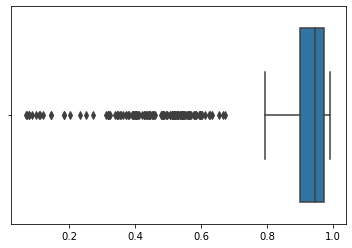

In [16]:
mean_auc_roc = defaultdict(list)
for key in pres.keys():
    mean_auc_roc[key].append(np.trapz(pres[key], rec[key])[0])

all_auc_roc = [i[0] for i in mean_auc_roc.values()]
    
sns.boxplot(all_auc_roc)

print(np.mean(all_auc_roc))

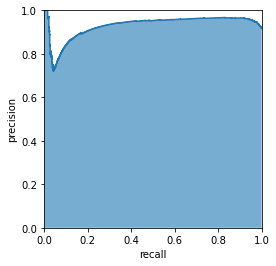

The Area is 0.932801684369982


In [17]:
# sample AUC-ROC curve

key = list(pres.keys())[0]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.step(rec[key][0], pres[key][0], where='post')
ax.fill_between(rec[key][0], pres[key][0], step='post', alpha=0.6)
    
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
    
ax.set_xlabel('recall')
ax.set_ylabel('precision')
plt.show()

print(f'The Area is {np.trapz(pres[key][0], rec[key][0])}') 

## Primary Committee per Congress Number

In [18]:
from tqdm import tqdm
from collections import defaultdict

dist = euclidean # can also be changed to manhattan, cosine gives an error

pres = defaultdict(list)
rec = defaultdict(list)

for s in tqdm(range(filtered.shape[0])):  # 100 is arbitrary, can be changed
    s = np.random.randint(filtered.shape[0])
    nearest = filtered.iloc[nearest_k(X_idf[s, :], X_idf, filtered.shape[0], dist)]
    r = np.cumsum(nearest['primary_committee'] == filtered['primary_committee'].iloc[s])
    precision = r/np.arange(1, len(r)+1)
    n = sum(filtered['primary_committee'] == filtered['primary_committee'].iloc[s])
    recall = r/n
    recall = [0] + recall.tolist()
    precision = [1] + precision.tolist()
    pres[s].append(precision)
    rec[s].append(recall)

100%|██████████████████████████████████████████████████████████████████████████████| 1728/1728 [00:54<00:00, 31.60it/s]


0.23657737903905263


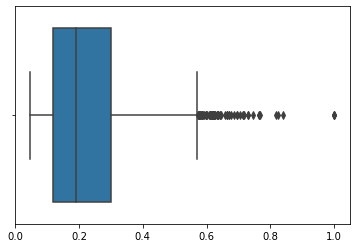

In [19]:
mean_auc_roc = defaultdict(list)
for key in pres.keys():
    mean_auc_roc[key].append(np.trapz(pres[key], rec[key])[0])

all_auc_roc = [i[0] for i in mean_auc_roc.values()]
    
sns.boxplot(all_auc_roc)

print(np.mean(all_auc_roc))

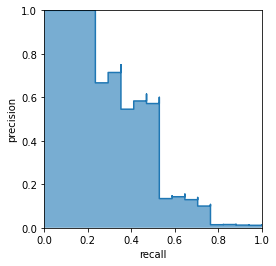

The Area is 0.4561695418593995


In [20]:
# sample AUC-ROC curve

key = list(pres.keys())[0]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.step(rec[key][0], pres[key][0], where='post')
ax.fill_between(rec[key][0], pres[key][0], step='post', alpha=0.6)
    
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
    
ax.set_xlabel('recall')
ax.set_ylabel('precision')
plt.show()

print(f'The Area is {np.trapz(pres[key][0], rec[key][0])}')

In [31]:
cols = ['bill_num', 'title', 'filed_by']
df = pd.read_pickle("../data_cleaning/labor.pkl")[cols]

In [32]:
df

,bill_num,title,filed_by
14144,240,EXCISE TAX ON MINERAL PRODUCTS,"[Sotto III, Vicente C, ]"
9424,748,TAX REFORM ACT,"[Ejercito-Estrada, Jinggoy P, ]"
1836,1838,VAT EXEMPT ON CERTAIN FOOD PRODUCTS/SERVICES,"[Drilon, Franklin M, , Flavier, Juan M, , Pangilinan, Francis N, , Gordon, Richard ""Dick"" J, ]"
6225,546,VALUE ADDED TAX ON DONATED IMPORTATIONS OF ITEMS OR GOODS,"[Ejercito-Estrada, Jinggoy P, ]"
9914,1238,PUBLIC SCHOOL TEACHERS' TAX INCENTIVE,"[Sotto III, Vicente C, ]"
